# Wet and Dry Years
## How monthly rainfall effects BC Wildfires
<img src="https://media.socastsrm.com/wordpress/wp-content/blogs.dir/2671/files/2020/09/canadas-wildfire-season-expected-to-be-well-above-average-natural-resources-canada.jpg" width="500" height="500" />

#### Every summer, wildfires engulf the province of British Columbia, costing the province millions of dollars in damages and associated firefighting costs. The scale of a wildfirefire can be represented by total hectares burned, a measure of the amount of land burned during the fire. A commonly cited metric for predicting the seasonal destruction of wildfires is the rainfall in the preceding months. 
#### This analysis seeks to understand the role of monthly precipitation in determining total hectares burned. Specifically, this analysis will examine how the total precipitation (TP) in the 1-6 months prior correlates with the total hectares burned in a given month, and if total precipitation is a reliable predictor of total hectares burned.

#### To make data collection more manageable this project is limited to the Southeast Fire Center, shown in this map.
<img src="http://castlegarsource.com/sites/default/files/newsimages/castlegarsourcecom/mar/bc_firecentres_colour.gif" width="500" height="500" />

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Importing and Cleaning Data
#### Determining the correlation between monthly rainfall and total hectares burned will require both weather and fire data. The province of British Columbia publishes a historic record of wildfires, all the way back to 1919. To ensure a high quality of data, I've chosen to limit my analysis to the years 2000-2021. 

#### Historic weather data is available through Environment Canada, but finding stations that report consistently through the analysis period is more challenging. I chose 9 evenly distributed weather stations from around the Southeast Fire Center with semi-consistent data between the years 2000-2021, which are listed in the python list 'cities'.

#### Getting a reliable reporting period presented another challenge. Environment Canada provides monthly values for most stations, but only until 2007. To make up for the lost years, I had to switch to daily weather data for 2008-2021. This created an extra step in the data cleaning process.

In [2]:
#opening up the fire data
fire_data = pd.read_csv('bc_fire_data/PROT_HISTORICAL_FIRE_POLYS_SP/H_FIRE_PLY.csv')
fire_data

,FIRE_NO,VERSION_NO,FIRE_YEAR,FIRE_CAUSE,FIRELABEL,SIZE_HA,SOURCE,TRACK_DATE,LOAD_DATE,FIRE_DATE,METHOD,FCODE,SHAPE,OBJECTID,AREA_SQM,FEAT_LEN,X,Y
0,114,NaN,1919,Person,1919-114,718.7,linens,NaN,2.007050e+13,1.919092e+07,digitised,JA70003000,NaN,1960546,7.187147e+06,12383.3801,NaN,NaN
1,118,NaN,1919,Person,1919-118,71.7,linens,NaN,2.007050e+13,1.919072e+07,assumed_shape,JA70003000,NaN,1960547,7.174560e+05,3549.4426,NaN,NaN
2,119,NaN,1919,Person,1919-119,162.7,linens,NaN,2.007050e+13,1.919101e+07,digitised,JA70003000,NaN,1960548,1.627569e+06,6136.5420,NaN,NaN
3,12,NaN,1919,Person,Dec-19,52.7,linens,NaN,2.007050e+13,1.919062e+07,digitised,JA70003000,NaN,1960549,5.274015e+05,2768.0699,NaN,NaN
4,122,NaN,1919,Person,1919-122,1336.5,linens,NaN,2.007050e+13,1.919083e+07,digitised,JA70003000,NaN,1960550,1.336539e+07,15084.4968,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474,R50250,2.020051e+09,2020,Person,2020-R50250,39.7,2020 ROLLOVER,20200512.0,2.020050e+13,2.020050e+13,Non-corrected airborne GPS,JA70003000,NaN,1982978,3.968806e+05,4366.5464,NaN,NaN
22475,V10062,2.020041e+09,2020,Person,2020-V10062,10.9,2020 ROLLOVER,20200414.0,2.020040e+13,2.020040e+13,Non-corrected ground GPS,JA70003000,NaN,1982979,1.090789e+05,1657.7826,NaN,NaN
22476,V10723,2.020073e+09,2020,Person,2020-V10723,1.1,2020 ROLLOVER,20200731.0,2.020090e+13,2.020070e+13,Non-corrected ground GPS,JA70003000,NaN,1982980,1.106624e+04,570.8552,NaN,NaN
22477,V10874,2.020081e+09,2020,Person,2020-V10874,15.4,2020 ROLLOVER,20200805.0,2.020080e+13,2.020080e+13,Non-corrected ground GPS,JA70003000,NaN,1982981,1.542843e+05,3053.0121,NaN,NaN


In [3]:
fire_center_codes = {'Cariboo' : 'C', 'Prince George':'G', 'Kamloops':'K', 'Southeast':'N', 'Northwest':'R', 'Coastal':'V'}

In [4]:
fire_data = fire_data[fire_data['FIRE_YEAR'] >= 2000]
fire_data = fire_data[['FIRE_NO', 'FIRE_YEAR', 'FIRE_CAUSE', 'FIRE_DATE', 'FIRELABEL', 'SIZE_HA', 'SOURCE', 'AREA_SQM']]
fire_data['FIRE_CENTER'] = fire_data['FIRE_NO'].str[:1]
fire_data['FIRE_DATE'] = fire_data['FIRE_DATE'].astype(str)
fire_data['FIRE_DATE'] = fire_data['FIRE_DATE'].str[:8]

In [5]:
fire_data.loc[(fire_data['FIRE_DATE'].str[6:8] == '00'), 'FIRE_DATE'] = fire_data['FIRE_DATE'].str[:-1] + '1'

In [6]:
fire_data['FIRE_DATE'] = pd.to_datetime(fire_data['FIRE_DATE'])
fire_data.set_index('FIRE_DATE', inplace = True)

In [7]:
fire_data = fire_data[(fire_data['FIRE_CENTER'] == fire_center_codes['Southeast'])]
fire_data = fire_data[['FIRE_CAUSE', 'SIZE_HA', 'SOURCE', 'AREA_SQM', 'FIRE_CENTER']]
fire_data.head()

,FIRE_CAUSE,SIZE_HA,SOURCE,AREA_SQM,FIRE_CENTER
FIRE_DATE,,,,,
2000-05-23,Person,60.4,fire centre,6.046447e+05,N
2000-08-10,Lightning,191.5,fire centre,1.915436e+06,N
2000-08-10,Lightning,72.4,fire centre,7.241036e+05,N
2000-08-10,Lightning,22.6,fire centre,2.263074e+05,N
2000-08-11,Lightning,232.6,Buffered_Point,2.326953e+06,N


In [8]:
fire_datax = fire_data.resample('M').sum()
fire_datax.index = pd.to_datetime(fire_datax.index, format = '%Y-%m-%d').strftime('%Y-%m')
fire_datax.head()

,SIZE_HA,AREA_SQM
FIRE_DATE,,
2000-04,1.4,1.420238e+04
2000-05,91.7,9.185620e+05
2000-06,0.0,0.000000e+00
2000-07,124.2,1.244821e+06
2000-08,1666.5,1.667784e+07


In [9]:
example = pd.read_csv('Southeast_Weather/Castlegar/Monthly/en_climate_monthly_BC_1141457_1969-2007_P1M.csv')
print(example.columns)
example.head()

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Year', 'Month', 'Mean Max Temp (°C)',
       'Mean Max Temp Flag', 'Mean Min Temp (°C)', 'Mean Min Temp Flag',
       'Mean Temp (°C)', 'Mean Temp Flag', 'Extr Max Temp (°C)',
       'Extr Max Temp Flag', 'Extr Min Temp (°C)', 'Extr Min Temp Flag',
       'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)',
       'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag',
       'Snow Grnd Last Day (cm)', 'Snow Grnd Last Day Flag',
       'Dir of Max Gust (10's deg)', 'Dir of Max Gust Flag',
       'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'],
      dtype='object')


,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-117.77,49.34,CASTLEGAR BCHPA DAM,1141457,1969-01,1969,1,NaN,M,NaN,...,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN
1,-117.77,49.34,CASTLEGAR BCHPA DAM,1141457,1969-02,1969,2,NaN,M,NaN,...,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN
2,-117.77,49.34,CASTLEGAR BCHPA DAM,1141457,1969-03,1969,3,NaN,M,NaN,...,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN
3,-117.77,49.34,CASTLEGAR BCHPA DAM,1141457,1969-04,1969,4,NaN,M,NaN,...,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN
4,-117.77,49.34,CASTLEGAR BCHPA DAM,1141457,1969-05,1969,5,NaN,M,NaN,...,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN


In [10]:
#Creating southeast_monthly
cities = ['Castlegar', 'Fernie', 'Golden', 'Kimberley', 'Mica Dam', 'Midway', 'Nakusp', 'Nelson', 'Revelstoke']
Southeast_monthly = pd.DataFrame()
for i in range(len(cities)):
    path = 'Southeast_Weather/'+cities[i]+'/Monthly/'
    files = [file for file in os.listdir(path) if not file.startswith('.')]
    for file in files:
        weather = pd.read_csv(path+file)
        weather = weather[['Date/Time', 'Total Precip (mm)','Station Name']]
        weather = weather[weather['Date/Time'] >= '1999-12-01']
        Southeast_monthly = pd.concat([Southeast_monthly, weather])
Southeast_monthly['Date/Time'] = pd.to_datetime(Southeast_monthly['Date/Time'])
Southeast_monthly.head()

,Date/Time,Total Precip (mm),Station Name
372,2000-01-01,NaN,CASTLEGAR BCHPA DAM
373,2000-02-01,NaN,CASTLEGAR BCHPA DAM
374,2000-03-01,NaN,CASTLEGAR BCHPA DAM
375,2000-04-01,NaN,CASTLEGAR BCHPA DAM
376,2000-05-01,NaN,CASTLEGAR BCHPA DAM


In [11]:
#Creating southeast daily
Southeast_daily = pd.DataFrame()
for i in range(len(cities)):
    path = 'Southeast_Weather/'+cities[i]+'/Daily/'
    files = [file for file in os.listdir(path) if not file.startswith('.')]
    for file in files:
        weather = pd.read_csv(path+file)
        weather = weather[['Date/Time', 'Total Precip (mm)','Station Name']]
        weather['Date/Time'] = pd.to_datetime(weather['Date/Time'])
        weather.set_index('Date/Time', inplace = True)
        weather ['Total Precip (mm)'] = weather['Total Precip (mm)'].resample('M').sum()
        weather.reset_index(inplace = True)
        weather = weather[weather['Date/Time'].dt.is_month_end]
        Southeast_daily = pd.concat([Southeast_daily, weather])
Southeast_daily.head()

,Date/Time,Total Precip (mm),Station Name
30,2008-01-31,75.8,CASTLEGAR BCHPA DAM
59,2008-02-29,27.2,CASTLEGAR BCHPA DAM
90,2008-03-31,29.6,CASTLEGAR BCHPA DAM
120,2008-04-30,29.5,CASTLEGAR BCHPA DAM
151,2008-05-31,18.6,CASTLEGAR BCHPA DAM


#### Now that the daily and monthly weather files have been cleaned and made uniform, I can combine them and index according to the month. I have also added 3 new columns.

In [12]:
Southeast = pd.concat([Southeast_monthly, Southeast_daily])
Southeast = Southeast.pivot(index='Date/Time', columns = 'Station Name', values= 'Total Precip (mm)')
Southeast.index = pd.to_datetime(Southeast.index, format = '%Y-%m-%d').strftime('%Y-%m')
Southeast.replace(0, np.nan, inplace=True)
Southeast['Measurements'] = Southeast.count(axis=1)
Southeast['Reporting Rate'] = round(Southeast['Measurements']/9,1)
Southeast['Avg Precip'] = round(Southeast.mean(axis=1),2)

Southeast = Southeast.drop(Southeast[Southeast['Measurements'] == 0].index)
Southeast.head()

Station Name,CASTLEGAR BCHPA DAM,FERNIE,GOLDEN A,KIMBERLEY PCC,MICA DAM,MIDWAY,NAKUSP CS,NELSON CS,REVELSTOKE A,Measurements,Reporting Rate,Avg Precip
Date/Time,,,,,,,,,,,,
2000-01,NaN,130.0,35.2,57.4,181.5,46.5,NaN,NaN,NaN,5,0.6,65.17
2000-02,NaN,115.3,35.8,36.0,82.1,29.6,63.6,56.8,NaN,7,0.8,47.44
2000-03,NaN,93.0,19.0,24.8,134.5,44.4,90.2,59.6,NaN,7,0.8,52.59
2000-04,NaN,88.0,22.0,26.6,62.4,25.3,78.4,73.0,NaN,7,0.8,42.61
2000-05,NaN,108.1,34.0,17.2,82.9,34.4,75.2,60.6,NaN,7,0.8,46.69


#### Since my dataset is missing weather data on certain dates, I wanted to be sure that the reporting rate did not have a significant effect on the Avg. Precipitation for a given month. In the table below, you can see that the correlation between Reporting Rate and Avg Precip is only 0.029, which is very close to 0. This indicates that the reporting rate does NOT have a significant correlation with my measurement of Average precipitation in the Southeast Fire center, and so I am safe to continue analysis.

In [13]:
Southeast.corr()

Station Name,CASTLEGAR BCHPA DAM,FERNIE,GOLDEN A,KIMBERLEY PCC,MICA DAM,MIDWAY,NAKUSP CS,NELSON CS,REVELSTOKE A,Measurements,Reporting Rate,Avg Precip
Station Name,,,,,,,,,,,,
CASTLEGAR BCHPA DAM,1.000000,0.521751,0.464598,0.514344,0.339950,0.706574,0.557448,0.831497,0.528562,0.064261,0.061529,0.738589
FERNIE,0.521751,1.000000,0.531251,0.437465,0.567735,0.346415,0.636437,0.670331,0.652768,-0.073537,-0.073537,0.830346
GOLDEN A,0.464598,0.531251,1.000000,0.433481,0.439065,0.382542,0.614477,0.541096,0.583737,0.116500,0.102435,0.700074
KIMBERLEY PCC,0.514344,0.437465,0.433481,1.000000,0.311700,0.454677,0.399032,0.538687,0.354174,-0.043529,-0.043529,0.594518
MICA DAM,0.339950,0.567735,0.439065,0.311700,1.000000,0.171260,0.622618,0.503547,0.651932,-0.145450,-0.157162,0.768272
MIDWAY,0.706574,0.346415,0.382542,0.454677,0.171260,1.000000,0.446176,0.619960,0.316126,0.153569,0.153569,0.572571
NAKUSP CS,0.557448,0.636437,0.614477,0.399032,0.622618,0.446176,1.000000,0.707552,0.717352,0.120415,0.109331,0.847092
NELSON CS,0.831497,0.670331,0.541096,0.538687,0.503547,0.619960,0.707552,1.000000,0.653671,0.203079,0.203079,0.869577
REVELSTOKE A,0.528562,0.652768,0.583737,0.354174,0.651932,0.316126,0.717352,0.653671,1.000000,-0.123038,-0.123038,0.827129


#### Reassured that the Reporting Rate is not adversely affecting my analysis, I replaced the missing values with the average  precipitation in that month and summed each row to produce total precipitation (TP) for each month.

In [14]:
Southeast['CASTLEGAR BCHPA DAM'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['FERNIE'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['GOLDEN A'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['KIMBERLEY PCC'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['MICA DAM'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['MIDWAY'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['NAKUSP CS'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['NELSON CS'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['REVELSTOKE A'].fillna(Southeast['Avg Precip'], inplace=True)
Southeast['Total Precip (TP)'] = round(Southeast[['CASTLEGAR BCHPA DAM', 'FERNIE', 'GOLDEN A', 'KIMBERLEY PCC', 'MICA DAM', 'MIDWAY',
                                      'NAKUSP CS', 'NELSON CS', 'REVELSTOKE A']].sum(axis=1),2)
Southeast.head()

Station Name,CASTLEGAR BCHPA DAM,FERNIE,GOLDEN A,KIMBERLEY PCC,MICA DAM,MIDWAY,NAKUSP CS,NELSON CS,REVELSTOKE A,Measurements,Reporting Rate,Avg Precip,Total Precip (TP)
Date/Time,,,,,,,,,,,,,
2000-01,65.17,130.0,35.2,57.4,181.5,46.5,65.17,65.17,65.17,5,0.6,65.17,711.28
2000-02,47.44,115.3,35.8,36.0,82.1,29.6,63.60,56.80,47.44,7,0.8,47.44,514.08
2000-03,52.59,93.0,19.0,24.8,134.5,44.4,90.20,59.60,52.59,7,0.8,52.59,570.68
2000-04,42.61,88.0,22.0,26.6,62.4,25.3,78.40,73.00,42.61,7,0.8,42.61,460.92
2000-05,46.69,108.1,34.0,17.2,82.9,34.4,75.20,60.60,46.69,7,0.8,46.69,505.78


## Data Transformation
#### Now that the data is cleaned and formatted correctly, I can transform my data to set the stage for analysis. The following data frame contains key statistics for each month.

In [15]:
fire_datay = pd.DataFrame(fire_datax.merge(Southeast, left_on = fire_datax.index, right_on = Southeast.index))
fire_datay = fire_datay[['key_0', 'SIZE_HA', 'Measurements', 'Avg Precip', 'Total Precip (TP)']]
fire_datay['key_0'] = pd.to_datetime(fire_datay['key_0'], format = '%Y-%m')
fire_datay = fire_datay.rename(columns = {'key_0':'Date', 'SIZE_HA':'HAs Burned'})
fire_datay = fire_datay.set_index('Date')
fire_datay.index = fire_datay.index.to_period('M')
fire_datay.head()

,HAs Burned,Measurements,Avg Precip,Total Precip (TP)
Date,,,,
2000-04,1.4,7,42.61,460.92
2000-05,91.7,7,46.69,505.78
2000-06,0.0,7,36.29,391.38
2000-07,124.2,7,32.02,344.44
2000-08,1666.5,7,19.68,208.66


## Modeling the data

#### A common concept in BC communities is that of wet and dry years. This refers to the precipitation in the months leading up to fire season. To properly understand the correlation between TP and total hectares burned, I decided to measure the precipitation in the 1-6 months leading up to a fire.

In [16]:
a = fire_datay.shift(1)
fire_datay['TP Last Month'] = a['Total Precip (TP)']

b = fire_datay.shift(2)
fire_datay['TP 2 Month Ago'] = b['Total Precip (TP)']

c = fire_datay.shift(3)
fire_datay['TP 3 Month Ago'] = c['Total Precip (TP)']

d = fire_datay.shift(4)
fire_datay['TP 4 Month Ago'] = d['Total Precip (TP)']

e = fire_datay.shift(5)
fire_datay['TP 5 Month Ago'] = e['Total Precip (TP)']

f = fire_datay.shift(6)
fire_datay['TP 6 Month Ago'] = f['Total Precip (TP)']

fire_datay.head(7)

,HAs Burned,Measurements,Avg Precip,Total Precip (TP),TP Last Month,TP 2 Month Ago,TP 3 Month Ago,TP 4 Month Ago,TP 5 Month Ago,TP 6 Month Ago
Date,,,,,,,,,,
2000-04,1.4,7,42.61,460.92,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,91.7,7,46.69,505.78,460.92,NaN,NaN,NaN,NaN,NaN
2000-06,0.0,7,36.29,391.38,505.78,460.92,NaN,NaN,NaN,NaN
2000-07,124.2,7,32.02,344.44,391.38,505.78,460.92,NaN,NaN,NaN
2000-08,1666.5,7,19.68,208.66,344.44,391.38,505.78,460.92,NaN,NaN
2000-09,0.0,7,48.36,524.12,208.66,344.44,391.38,505.78,460.92,NaN
2000-10,53.5,7,37.68,406.66,524.12,208.66,344.44,391.38,505.78,460.92


## Insights
#### The table below shows the final results of this analysis. It shows the correlation between TP and Total Hectares burned in the 1-6 months prior. None of these values are close enough to 1 or -1 to provide evidence for TP to be used as a predictor of Total Hectares burned, so I will not proceed with a liniar regression. This relationship is best evidenced in Figure 1. However, correlation does change over time, shown in Figure 2 below. As expected, correlation is strongest for TP in the same month and decreases as time passes. What is interesting is that around 4 months prior, TP starts to have a positive correlation with Total Hectares burned. This relationship reaches its peak at 5 months prior, indicating that more rain fall 5 months before a fire is slightly correlated with larger fire sizes.

In [17]:
z = fire_datay.corr()
y = z['HAs Burned']
x = y[['Total Precip (TP)', 'TP Last Month', 'TP 2 Month Ago', 'TP 3 Month Ago', 'TP 4 Month Ago', 'TP 5 Month Ago', 'TP 6 Month Ago']]
x

Total Precip (TP)   -0.257928
TP Last Month       -0.199038
TP 2 Month Ago      -0.080808
TP 3 Month Ago      -0.037623
TP 4 Month Ago       0.081718
TP 5 Month Ago       0.133390
TP 6 Month Ago       0.018104
Name: HAs Burned, dtype: float64

#### Figure 1

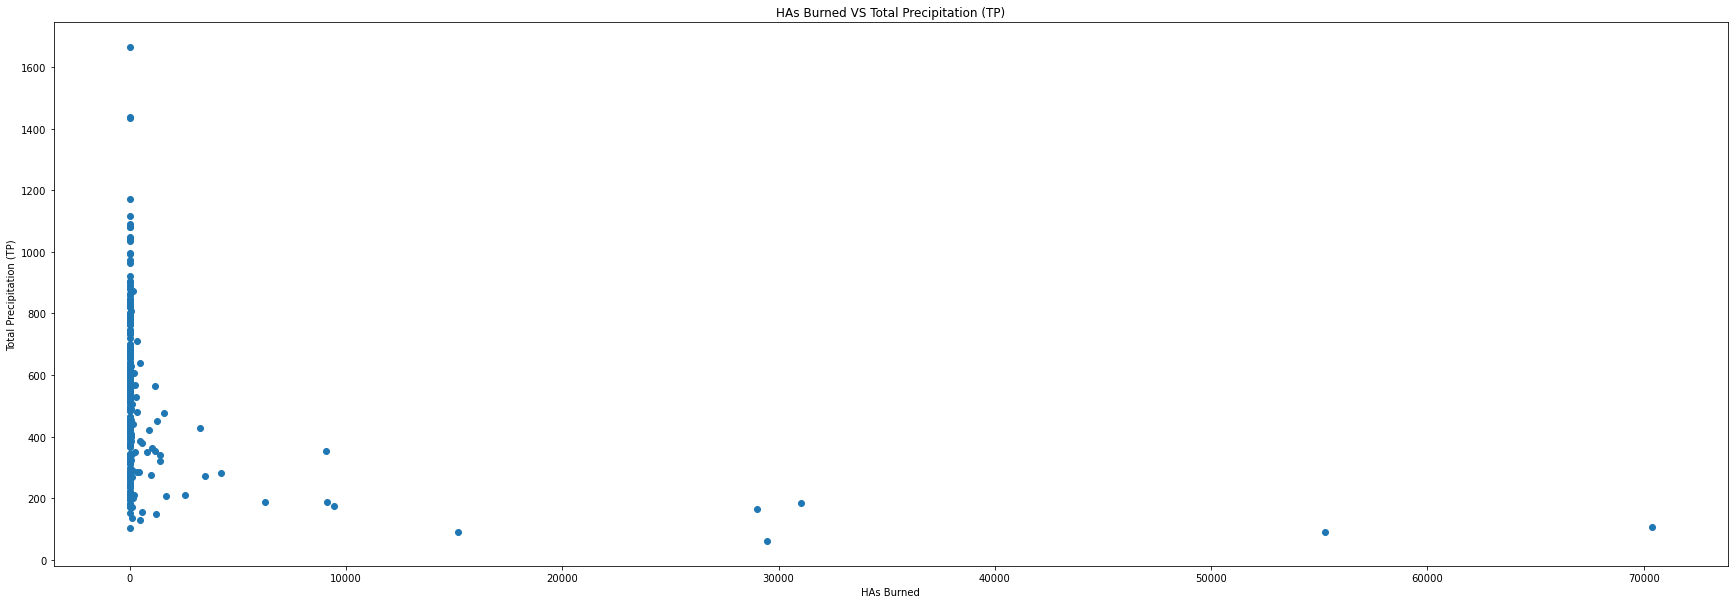

In [18]:
plt.figure(figsize=(30,10))
plt.scatter(fire_datay['HAs Burned'], fire_datay['Total Precip (TP)'])
plt.ylabel('Total Precipitation (TP)')
plt.title('HAs Burned VS Total Precipitation (TP)')
plt.xlabel('HAs Burned')
plt.show()

#### Figure 2

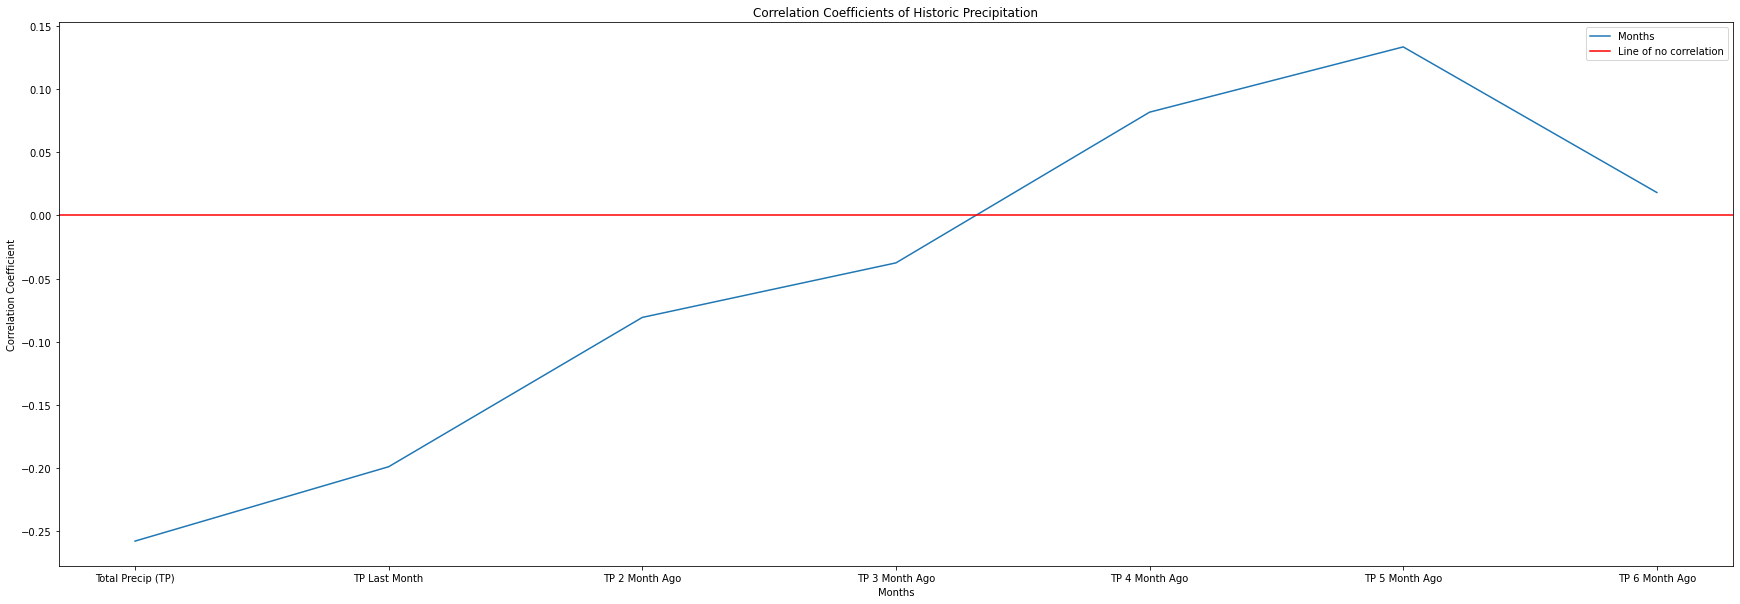

In [19]:
plt.figure(figsize=(30,10))
plt.plot(x, label = 'Months')
plt.title('Correlation Coefficients of Historic Precipitation')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Months')
plt.axhline(y=0, color='r', linestyle='-', label = 'Line of no correlation')
plt.legend()
plt.show()

#### To investigate why the rainfall 5 months before a fire has a positive relationship with total hectares burned, it is helpful to understand the distribution of fires throughout the year. In the histogram below, we can see that the vast majority of wildfires occur in the 7th and 8th months, July and August. When we subtract 5 months from these dates, we find that the rainfall correlated with larger fires occurs mostly in February and March. In the Southeast Fire center, February and March are considered early spring. It is possible that an increase in rainfall in these months could lead to increased growth in the forests of the area, creating more plant life and therefore more fuel for wildfires to burn.

#### Figure 3

Text(0.5, 1.0, 'Distribution of Fires')

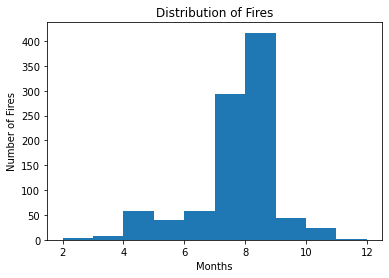

In [20]:
plt.figure()
plt.hist(fire_data.index.month)
plt.ylabel('Number of Fires')
plt.xlabel('Months')
plt.title('Distribution of Fires')

## Conclusion
#### The goal of this analysis was to understand how precipitation in preceding months correlates with wildfire size, and if precipitation can be used as a pleading indicator of fire size. By calculating the correlation coefficient between HAs Burned and the 1-6 months leading up to a fire, I determined that there is not a strong enough relationship for total precipitation to be used as a leading indicator of wildfire size. This is likely due to the many factors that determine wildfire size, including fuel levels and attention from wildfire crews. 
#### By comparing correlation coefficients for a range of 1-6 months, I learned that while the relationship is not strong, the strength of the relationship is strongest in the most recent month. Interestingly, there is evidence that precipitation 5 months before a fire has a positive relationship with the size of the fire. By measuring the distribution of fires throughout the year and subtracting 5 months, I determined that this precipitation occurs in the early spring months of February and March. This may be grounds for further study to understand the relationship between the early spring growing season and wildfires in the summer.